<a href="https://colab.research.google.com/github/NikitaKolchik/safety-vest-videos/blob/master/vestDet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Safety vest detection

1. The first thing we need to do is to create the dataset of safety vests
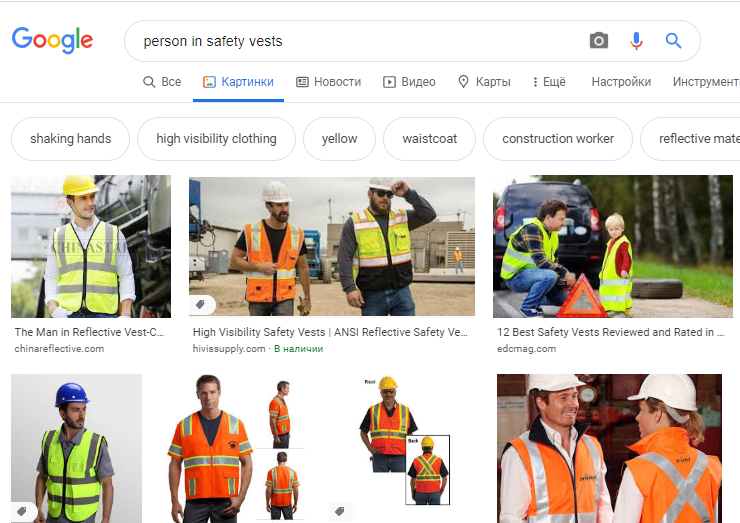 

# 1.   I've downloaded 62 pictures of people in safety vests and labeled all the vests on them with labelImg-master (https://github.com/tzutalin/labelImg)
# 2.   As annotations(labels) of labelImg-master are in XML-format, I needed to change their format to json with roboflow.ai 
# 3.   I did that because I will be using DETECTRON2 library for our vests detection and this library requires json-annotations



In [ ]:
#IMPORT MY LABELLED DATASET WITH LINK FROM ROBOFLOW AI
!curl -L "https://app.roboflow.ai/ds/VOsm3RhXHL?key=CPFC6tLizg" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0    847      0  0:00:01  0:00:01 --:--:--   847
100 1901k  100 1901k    0     0  1462k      0  0:00:01  0:00:01 --:--:-- 1462k
Archive:  roboflow.zip
 extracting: train/0046_jpg.rf.1801da614cc4b670fe51313121260f0e.jpg  
 extracting: train/0031_jpg.rf.13d281d130408b8b73e6a64c27a3cccd.jpg  
 extracting: train/0028_jpg.rf.7b5ce9af224eadc4c6f4addf07f6e83a.jpg  
 extracting: train/0005_jpg.rf.679d519bee19f80b5a147135b4438b66.jpg  
 extracting: train/0043_jpg.rf.80d4791fe457a2b1459294d774c574a1.jpg  
 extracting: train/0035_jpg.rf.1063fa53e75770b42be430706a13d697.jpg  
 extracting: train/0037_jpg.rf.798ed79c77a6958b504d5047c4978c13.jpg  
 extracting: test/0009_jpg.rf.a1b8adc4b29146ab3a0a2e629f86c30b.jpg  
 extracting: train/0036_jpg.rf.80e0aaf8291182af51e9866fa92e5efe.jpg  
 extracting: train/0026_png.rf.4

# Then we import all needed libraries

In [ ]:
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=ade200761b739fd2bbe80b1f104194ca13902700a2637f9b17af80078a9aac8b
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-a9mm8_y0
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-a9mm8_y0
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266454 sha256=3e94ff536528e02b833488649613c9df65c35d44f72d4f1e8d79db7a96fbc6bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-oirzmmcj/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing install

In [ ]:
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import detectron2
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

In [ ]:
from detectron2.data.datasets import register_coco_instances
#register our dataset
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")


#Visualise our labelled images

WARNING [07/16 11:11:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/16 11:11:24 d2.data.datasets.coco]: Loaded 44 images in COCO format from /content/train/_annotations.coco.json


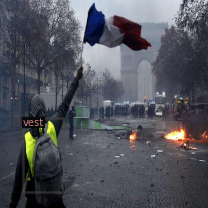

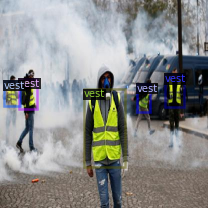

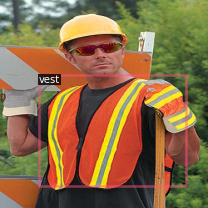

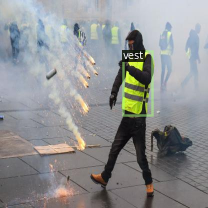

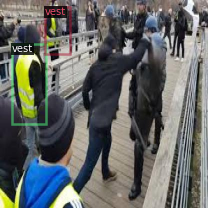

In [ ]:
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from detectron2.utils.visualizer import Visualizer

train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
#IMPORTING GET_CFG TO CHOOSE MODEL, EPOCHS,BATCH SIZE ETC.
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 4


cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 #your number of classes + 1


cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.MAX_ITER = 600 
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

cfg.TEST.EVAL_PERIOD = 500
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/16 11:17:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:36, 11.6MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.


[07/16 11:18:43 d2.engine.train_loop]: Starting training from iteration 0
[07/16 11:20:17 d2.utils.events]:  eta: 0:47:02  iter: 19  total_loss: 2.015  loss_cls: 1.030  loss_box_reg: 0.859  loss_rpn_cls: 0.048  loss_rpn_loc: 0.022  time: 4.7186  data_time: 0.0294  lr: 0.000039  max_mem: 7207M
[07/16 11:21:53 d2.utils.events]:  eta: 0:45:36  iter: 39  total_loss: 1.735  loss_cls: 0.786  loss_box_reg: 0.855  loss_rpn_cls: 0.036  loss_rpn_loc: 0.016  time: 4.7353  data_time: 0.0164  lr: 0.000079  max_mem: 7207M
[07/16 11:23:26 d2.utils.events]:  eta: 0:43:59  iter: 59  total_loss: 1.542  loss_cls: 0.569  loss_box_reg: 0.919  loss_rpn_cls: 0.041  loss_rpn_loc: 0.026  time: 4.7150  data_time: 0.0192  lr: 0.000119  max_mem: 7207M
[07/16 11:24:59 d2.utils.events]:  eta: 0:42:21  iter: 79  total_loss: 1.339  loss_cls: 0.427  loss_box_reg: 0.884  loss_rpn_cls: 0.029  loss_rpn_loc: 0.019  time: 4.6944  data_time: 0.0123  lr: 0.000159  max_mem: 7207M
[07/16 11:26:31 d2.utils.events]:  eta: 0:40:4

In [ ]:
#test
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

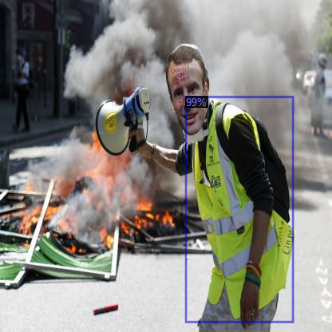

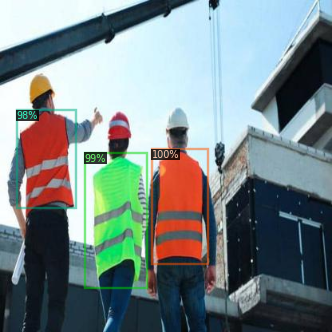

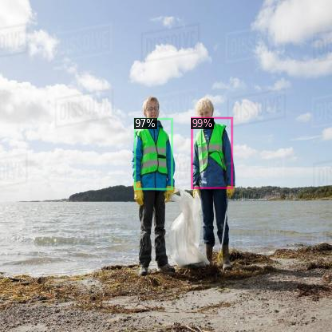

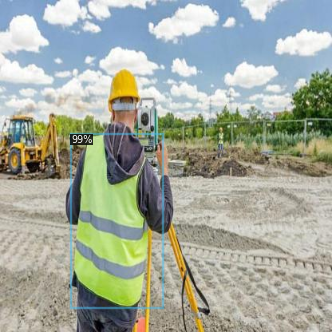

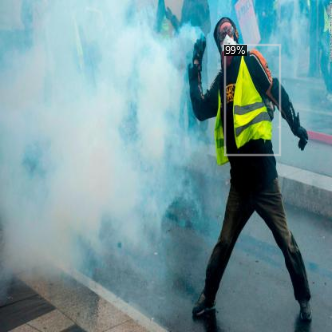

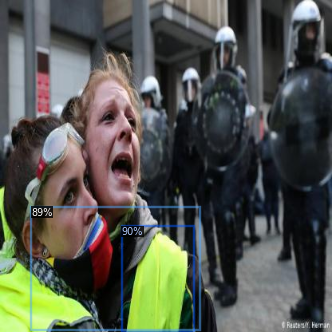

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])


# Now as we trained our model, we can detect safety vests on video.
# For this reason we import imageio to split our video by frames


In [ ]:
# I PUT MY VIDEO TO GITHUB  
! git clone https://github.com/NikitaKolchik/safety-vest-videos


Cloning into 'safety-vest-videos'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [ ]:
import imageio

video = 'safety-vest-videos/VESTS_8_SEC.mp4'
reader = imageio.get_reader(video)
fps = reader.get_meta_data()['fps']
#fps = 30 in our case

# !!! you need to wait +- 30 seconds after the next cell finishes  and a new video will be created ('output.mp4'), then download it

# I cut this video up to 8 seconds to shorten time of detection

In [ ]:

writer = imageio.get_writer('output.mp4',fps=fps) #create a new video
for i,frame in enumerate(reader):
  output = predictor(frame) #detect vests frame by frame
  v = Visualizer(frame[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(output["instances"].to("cpu")) #draw rectangles when vest detected
  writer.append_data(out.get_image()[:, :, ::-1]) #append frames to a new video
  print(i)

writer.close()



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254


In [ ]:
from google.colab import files

uploaded = files.download('output.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# You can see results here :
https://github.com/NikitaKolchik/safety-vest-videos/blob/master/after.mp4